In [6]:
from IPython.display import clear_output
clear_output()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import os
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import anndata as ad

# L1000 genes

Not explicitly mentioned, for my own curiosity.

In [137]:
L1000_genes = (
    pd.read_csv('L1000_gene_info.tsv', delimiter='\t')
      .pipe(lambda df: df[df['pr_is_lm'] == 1])
)['pr_gene_symbol'].tolist()

len(L1000_genes)

978

# BROAD Compound Info

Just another source of compound metadata

In [191]:
LINCS_pert_info = (
    pd.read_csv('GSE92742_Broad_LINCS_pert_info.txt', delimiter='\t')
        .replace('-666', np.nan)
        .dropna(subset=['canonical_smiles'])
)

LINCS_pert_info.head()

,pert_id,pert_iname,pert_type,is_touchstone,inchi_key_prefix,inchi_key,canonical_smiles,pubchem_cid
98,BRD-A00100033,nifurtimox,trt_cp,1,ARFHIAQFJWUCFH,ARFHIAQFJWUCFH-UHFFFAOYSA-N,CC1CS(=O)(=O)CCN1N=Cc1ccc(o1)[N+]([O-])=O,6842999
99,BRD-A00150179,5-hydroxytryptophan,trt_cp,0,QSHLMQDRPXXYEE,QSHLMQDRPXXYEE-UHFFFAOYSA-N,NC(Cc1c[nH]c2cccc(O)c12)C(O)=O,589768
100,BRD-A00267231,hemado,trt_cp,1,KOCIMZNSNPOGOP,KOCIMZNSNPOGOP-UHFFFAOYSA-N,CCCCC#Cc1nc(NC)c2ncn(C3OC(CO)C(O)C3O)c2n1,4043357
101,BRD-A00420644,SA-3676,trt_cp,0,ASCBUEVCEVGOFP,ASCBUEVCEVGOFP-UHFFFAOYSA-N,CCN1C2C(C(=NC2Nc3ccccc13)OC)c4ccccc4,2853908
102,BRD-A00474148,BRD-A00474148,trt_cp,0,RCGAUPRLRFZAMS,RCGAUPRLRFZAMS-UHFFFAOYSA-N,Oc1ccc(cc1)N1CCN(CC1)[S+]([O-])(=O)c1ccc2NC(=O...,44825297


# Small molecules from RXRX3 targets

o1-derived

In [3]:
small_molecule_targets = (
    pd.read_csv('small_molecule_targets.tsv', delimiter='\t', index_col=0)
        .reset_index(drop=True)
        # .assign(targets=lambda df: df['targets'].map(lambda x: x.split(',')))
        # .explode('targets')
)

small_molecule_targets

,compound,targets
0,Ulixertinib,MAPK1
1,Ulixertinib,MAPK3
2,BI 2536,PLK1
3,Neratinib,EGFR
4,Neratinib,ERBB2
...,...,...
291,Trametinib,MAP2K1
292,Trametinib,MAP2K2
293,OSI-027,MTOR
294,NVP-AEW541,IGF1R


# RXRX3 Metadata

- 17,063 genes + 1 for EMPTY_control
- 1672 compounds + EMPTY_control + CRISPR_control
- 16,328 are anonymized (735 are named)
- Each gene gets 6 guides to knock it out.
- There are 9 plates for CRISPR KOs
- Outliers are removed (you'll see that EGFR has less than 54)
- For some reason some (all?) genes have two experiments. 45 genes have != 2, some have 4, some have 176, some have 1

MTOR, EIF3H, PLK1, SRC, HCK, CYP11B1 show up in 176 experiments.

In [4]:
rxrx3_metadata = (
    pd.read_csv('rxrx3/metadata_rxrx3.csv')
      .assign(
          guide=lambda df: df['treatment'].str.extract('(guide_\d)')
      )
)

/tmp/ipykernel_22195/2448598311.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv('rxrx3/metadata_rxrx3.csv')


In [5]:
rxrx3_metadata['gene'].dropna().unique().shape[0]  # Number of CRISPR KOs
rxrx3_metadata[rxrx3_metadata['gene'].isna()].drop_duplicates('treatment').shape[0]  # Number of compounds
# rxrx3_metadata['perturbation_type'].value_counts()

17064

1676

In [169]:
treatments = rxrx3_metadata[rxrx3_metadata['gene'].isna()].drop_duplicates('treatment')['treatment'].tolist()

In [10]:
rxrx19a_metadata = pd.read_csv('data/rxrx19a_metadata.csv', index_col=0)
rxrx19b_metadata = pd.read_csv('data/rxrx19b_metadata.csv', index_col=0)
rxrx19_treatments = set(rxrx19a_metadata['treatment'].tolist() + rxrx19b_metadata['treatment'].tolist())

len(rxrx19a_metadata['treatment'].unique())
len(rxrx19b_metadata['treatment'].unique())
len(rxrx19_treatments)

1670

1857

1857

In [178]:
len(rxrx19_treatments.intersection(treatments))  # 1542 overlaps with RXRX19

1542

In [259]:
small_molecules = [
    x for x in treatments if \
    x.endswith('ib') \
    or x.startswith('OSI') \
    or x.startswith('GSK') \
    or x.startswith('AZD') \
    or x.startswith('BI ') \
    or x.startswith('KPT') \
    or x.startswith('GDC') \
    or x.startswith('BMS') \
    or x.startswith('ABT') \
    or x.startswith('PF') \
    or x.startswith('CPI') \
    or x.startswith('NVP')
]  # These should have genes they inhibit

len(small_molecules)

112

In [264]:
[m for m in small_molecules if m.startswith('NVP')]

['NVP-AEW541', 'NVP-TAE 684']

In [ ]:
rxrx3_metadata[rxrx3_metadata['treatment'].isin(small_molecules)]

,well_id,experiment_name,plate,address,gene,treatment,SMILES,concentration,perturbation_type,cell_type,guide
190,compound-001_47_F12,compound-001,47,F12,NaN,Ulixertinib,CC(C)NC1=NC=C(Cl)C(=C1)C1=CNC(=C1)C(=O)N[C@H](...,0.1000,COMPOUND,HUVEC,NaN
375,compound-004_31_C45,compound-004,31,C45,NaN,Neratinib,CCOC1=CC2=C(C=C1NC(=O)\C=C\CN(C)C)C(NC1=CC(Cl)...,0.1000,COMPOUND,HUVEC,NaN
1169,compound-004_33_I38,compound-004,33,I38,NaN,Tivozanib,COC1=CC2=C(C=C1OC)C(OC1=CC=C(NC(=O)NC3=NOC(C)=...,0.0250,COMPOUND,HUVEC,NaN
1808,compound-003_10_I25,compound-003,10,I25,NaN,Bortezomib,CC(C)C[C@H](NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)C1=...,0.0025,COMPOUND,HUVEC,NaN
2146,compound-004_42_S17,compound-004,42,S17,NaN,Bafetinib,CN(C)C1CCN(CC2=C(C=C(C=C2)C(=O)NC2=CC(NC3=NC=C...,0.0100,COMPOUND,HUVEC,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1162770,compound-004_30_U13,compound-004,30,U13,NaN,Olaparib,FC1=C(C=C(CC2=NNC(=O)C3=C2C=CC=C3)C=C1)C(=O)N1...,2.5000,COMPOUND,HUVEC,NaN
1163216,compound-003_4_B42,compound-003,4,B42,NaN,Bortezomib,CC(C)C[C@H](NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)C1=...,2.5000,COMPOUND,HUVEC,NaN
1163287,compound-003_13_S36,compound-003,13,S36,NaN,Trametinib,CN1C(=O)C(C)=C2N(C(=O)N(C3CC3)C(=O)C2=C1NC1=CC...,10.0000,COMPOUND,HUVEC,NaN
1163443,compound-001_45_O20,compound-001,45,O20,NaN,Acalabrutinib,CC#CC(=O)N1CCC[C@H]1C1=NC(=C2N1C=CN=C2N)C1=CC=...,1.0000,COMPOUND,HUVEC,NaN


# Get the named genes that have CRISPR KOs

735 named genes.

ABCC1 and EGFR are named. Let's use that for some closer looks. 

In [44]:
named_gene_metadata = rxrx3_metadata[(
    ~rxrx3_metadata['treatment'].str.contains('RXRX3')) \
    & (rxrx3_metadata['SMILES'].isna()) \
    & (~rxrx3_metadata['gene'].isna()) \
    & (rxrx3_metadata['treatment'] != 'EMPTY_control')
]
genes = named_gene_metadata['gene'].unique().tolist()
len(genes)

735

In [308]:
for g in genes:
    print(g)

AP2S1
IMPDH1
RPLP2
HRAS
RPEL1
FGF18
RPS6
TECR
BCL2
SEC23A
SNRPD3
ACADM
MTOR
CENPT
INTS7
RPL30
THOC1
SEH1L
IMPDH2
HTR6
ADCY2
INTS11
ACTB
RPL7A
XPO1
ICAM1
EIF3L
IDH3G
CXXC1
ATP6V1E1
HSD17B12
EIF3H
RFC2
BAAT
PTAFR
MAPKAPK5
DLST
THOC2
PLK1
F10
SRC
SEC31A
MAGOHB
AR
ADORA1
DERA
CYP51A1
EIF3B
CDK4
RAC1
RPL23A
P2RY12
CHRM1
CAB39L
SEC24D
TTR
AKR1B1
RPL13A
OXTR
POLR2A
GSK3A
GABRA1
FAAH
ATP6V1H
TBXA2R
TUBA1B
SLC27A6
NR3C2
AFDN
ABCC1
EGF
F2
GRIA2
EGFR
SLC29A1
COPG1
RBKS
AKT2
CHRM2
SV2A
LPAR1
PNLIP
ACTL6A
NECTIN3
ACE
IGF1R
TSPYL2
OGFOD1
MDM2
TH
SRD5A1
EDNRB
SLC6A4
ACOT8
SI
INTS2
POLR2I
CAMK2B
TYR
UTP20
TBCD
CTNND1
IDH2
FGFR2
RIPK1
PRKX
RAF1
PDE3A
PRMT5
MTNR1A
ADRA1B
STRADA
JAK3
HCK
AKT3
HSP90AA1
SLC27A4
CASC3
PTPN1
TUBA8
RPE
INTS14
SLC6A2
EIF3M
FRK
IDH1
CA9
ITGB3
PPARG
CXCL8
TAB2
MED14
GRIA4
NUP205
COPE
HDAC1
TUBA4B
CHRNB2
TRPA1
MLYCD
COX17
ACADS
RPS15
CCNG1
SLC5A2
PEX12
CDK2
CDH1
BCL10
BTK
CPS1
COPZ1
TUBB1
CHRNE
OPRD1
SPCS1
OPRM1
FGFR4
ADORA2A
EIF3K
CLDN14
NTRK1
MED16
CHEK2
DYNC1I2
RFC1
RPS6KB1
CL

## I just want to see how much the 735 named genes overlap with the L1000

I wonder why they chose these 735 then. I was guessing they were L1000 genes.

In [148]:
len(set(L1000_genes).intersection(genes))

99

# Check which small molecules targets overlap with named genes

69 compounds overlap with one of the named CRISPR KOs

In [276]:
small_molecule_targets.pipe(lambda df: df[df['targets'].isin(genes)])['compound'].unique().shape

(109,)

In [158]:
num_genes_gt2_exps = 0
for gene in genes:
    md = named_gene_metadata.pipe(lambda df: df[df['gene'] == gene])
    num_experiments = md['experiment_name'].unique().shape[0]
    if num_experiments != 2:
        print(gene, num_experiments)
        num_genes_gt2_exps += 1
num_genes_gt2_exps
# abcc1_metadata = named_gene_metadata.pipe(lambda df: df[df['gene'].isin(['ABCC1'])])
# egfr_metadata = named_gene_metadata.pipe(lambda df: df[df['gene'].isin(['EGFR'])])

# abcc1_metadata

MTOR 176
ACTB 4
ATP6V1E1 4
EIF3H 176
DLST 4
THOC2 1
PLK1 176
SRC 176
RAC1 4
RPL23A 4
AKR1B1 4
GABRA1 4
SRD5A1 4
PRKX 4
HCK 176
HDAC1 4
RPS15 4
CDH1 1
RBM8A 1
CYP11B1 176
ATP5F1C 4
OGDH 1
APH1A 1
MAP2K2 4
CTNNA1 4
SEC11A 4
PGD 4
ADCY1 4
SRP14 4
EIF3D 1
MAOA 4
HDAC6 1
ACTG1 4
RAB1B 4
KIF11 1
PTGS2 1
ALYREF 1
RPS2 4
EIF3I 1
RPL10 4
SEC13 1
PDE4A 1
CYP46A1 1
JAK2 1
RPL5 4


45

In [1]:
named_gene_metadata.pipe(lambda df: df[df['gene'] == 'EGFR'])

NameError: name 'named_gene_metadata' is not defined

In [123]:
# rxrx3_metadata[rxrx3_metadata['gene'] == 'ABCC1']['experiment_name'].value_counts()
# rxrx3_metadata[rxrx3_metadata['gene'] == 'EGFR']['experiment_name'].value_counts()
# rxrx3_metadata[rxrx3_metadata['experiment_name'] == 'gene-081']['experiment_name'].value_counts()

rxrx3_metadata['plate'].value_counts()

1     239294
6     239261
3     239256
5     239024
8     238592
4     238332
7     237239
2     236601
9     236320
15      2887
16      2702
13      2699
14      2642
24      2276
21      2275
18      2272
19      2091
22      2090
27      2084
30      2083
33      2083
36      2080
17      2030
23      2030
20      2029
26      1981
32      1980
29      1979
35      1978
11      1974
12      1968
10      1899
25      1869
34      1869
28      1868
31      1866
42      1772
48      1772
39      1769
45      1767
46      1708
40      1707
43      1706
37      1700
44      1678
41      1678
47      1676
38      1667
Name: plate, dtype: int64

In [125]:
rxrx3_metadata[(
    ~rxrx3_metadata['treatment'].str.contains('RXRX3')) \
    & (rxrx3_metadata['SMILES'].isna()) \
    & (~rxrx3_metadata['gene'].isna()) \
    & (rxrx3_metadata['treatment'] != 'EMPTY_control')
]

,well_id,experiment_name,plate,address,gene,treatment,SMILES,concentration,perturbation_type,cell_type,guide
58,gene-032_7_D27,gene-032,7,D27,AP2S1,AP2S1_guide_6,NaN,NaN,CRISPR,HUVEC,guide_6
135,gene-058_9_J19,gene-058,9,J19,IMPDH1,IMPDH1_guide_1,NaN,NaN,CRISPR,HUVEC,guide_1
156,gene-079_8_H29,gene-079,8,H29,RPLP2,RPLP2_guide_4,NaN,NaN,CRISPR,HUVEC,guide_4
176,gene-023_2_AB40,gene-023,2,AB40,HRAS,HRAS_guide_1,NaN,NaN,CRISPR,HUVEC,guide_1
200,gene-082_4_F32,gene-082,4,F32,RPEL1,RPEL1_guide_4,NaN,NaN,CRISPR,HUVEC,guide_4
...,...,...,...,...,...,...,...,...,...,...,...
2222004,gene-176_1_E35,gene-176,1,E35,PSMB8,PSMB8_guide_6,NaN,NaN,CRISPR,HUVEC,guide_6
2222041,gene-176_6_T13,gene-176,6,T13,PEX6,PEX6_guide_2,NaN,NaN,CRISPR,HUVEC,guide_2
2222068,gene-176_8_I27,gene-176,8,I27,ACAA2,ACAA2_guide_4,NaN,NaN,CRISPR,HUVEC,guide_4
2222077,gene-176_4_C35,gene-176,4,C35,FBL,FBL_guide_5,NaN,NaN,CRISPR,HUVEC,guide_5


In [73]:
# named_gene_metadata.sort_values(by=['gene', 'guide', 'plate']).head(18)

In [27]:
control_metadata = rxrx3_metadata[(
    ~rxrx3_metadata['treatment'].str.contains('RXRX3')) \
    & (rxrx3_metadata['SMILES'].isna()) \
    & (~rxrx3_metadata['gene'].isna()) \
    & (rxrx3_metadata['treatment'] == 'EMPTY_control')
]
control_metadata.shape

(183143, 10)

# RXRX3 Embeddings

In [101]:
from pathlib import Path
def collect_gene_embeddings(gene_name):
    embeddings_folder = Path(f'rxrx3/embeddings/embeddings/{gene_name}')
    all_embeddings = []
    for plate_folder in embeddings_folder.glob('Plate*'):
        plate_name = plate_folder.stem
        parquet_file = plate_folder / 'embeddings.parquet'
        embeddings = pd.read_parquet(parquet_file)
        embeddings = embeddings.set_index('well_id')
        embeddings['plate'] = plate_name
        all_embeddings.append(embeddings)
    all_embeddings = pd.concat(all_embeddings)
    return all_embeddings
        
gene_081_embeddings = collect_gene_embeddings('gene-081')
gene_081_embeddings.shape
# gene_081_embeddings = pd.read_parquet(
#     path='rxrx3/embeddings/embeddings/gene-081/Plate1/embeddings.parquet'
# )

# gene_081_embeddings

(12420, 129)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,plate
well_id,,,,,,,,,,,,,,,,,,,,,
gene-081_6_AC34,-0.056885,0.363932,-0.445847,0.766937,0.086323,0.133610,0.264962,1.282581,0.419440,-0.571592,...,-0.709677,0.357856,-0.980205,-1.061022,-0.010628,-1.016141,-1.689965,1.389497,-0.064634,Plate6
gene-081_6_AD22,1.341907,-0.533134,-1.404735,0.226849,1.522001,0.068837,-0.543011,1.280566,0.488329,-0.136745,...,-0.388397,-0.947273,-1.799352,-0.357466,0.024681,1.362462,-1.219223,1.029359,0.737789,Plate6
gene-081_6_J18,0.621577,0.675444,1.099783,-1.153920,1.204105,0.511852,-0.480592,0.049681,0.136142,-0.875173,...,-0.169898,0.854864,0.417799,1.540766,0.328417,0.640474,-1.186026,-0.287288,0.552587,Plate6
gene-081_6_M23,0.300212,0.406816,-1.063638,-1.046787,-0.850103,1.206619,-0.975127,0.773776,-0.517234,0.405022,...,0.676206,-0.105685,-1.628615,1.381960,-0.297555,-0.777632,0.730447,-0.448281,-0.396400,Plate6
gene-081_6_O39,0.026827,-1.490166,0.584655,-0.535580,-1.544502,2.308698,1.419570,0.357503,-0.990066,-0.800347,...,0.628450,0.544141,0.872454,0.809866,0.101863,-1.515176,0.369669,-0.456526,-0.078381,Plate6
gene-081_6_T24,-1.255994,-1.018462,2.281402,-0.809976,1.458813,1.371323,0.008169,-1.560204,-0.628847,-1.356698,...,0.597337,1.085486,1.894968,1.201467,0.481602,0.282091,-0.802888,0.255314,0.319182,Plate6
gene-081_9_AC19,0.920552,-0.346606,0.088493,0.128753,-0.758372,-1.125300,0.807115,1.266523,-0.523016,0.443022,...,-0.789047,-0.000872,-1.200226,-0.763075,1.058016,0.588477,-2.016010,1.864698,-0.797188,Plate9
gene-081_9_J12,0.638124,0.385139,0.776677,-0.535659,2.147259,-0.134512,-0.862762,-1.414733,-0.184297,-1.031068,...,-0.515193,0.412039,1.155567,0.241540,-0.123609,0.482410,-1.424492,0.062577,1.329187,Plate9
gene-081_9_J42,-0.329302,-0.320189,-0.585511,-1.304527,2.135825,0.281756,-2.026213,-0.467153,-0.870283,0.185048,...,0.098012,0.024248,-0.108578,-0.040213,0.739097,0.499673,-0.199659,0.150906,-0.652816,Plate9


/tmp/ipykernel_26705/2964040479.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.clustermap(gene_081_embeddings.corr())
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


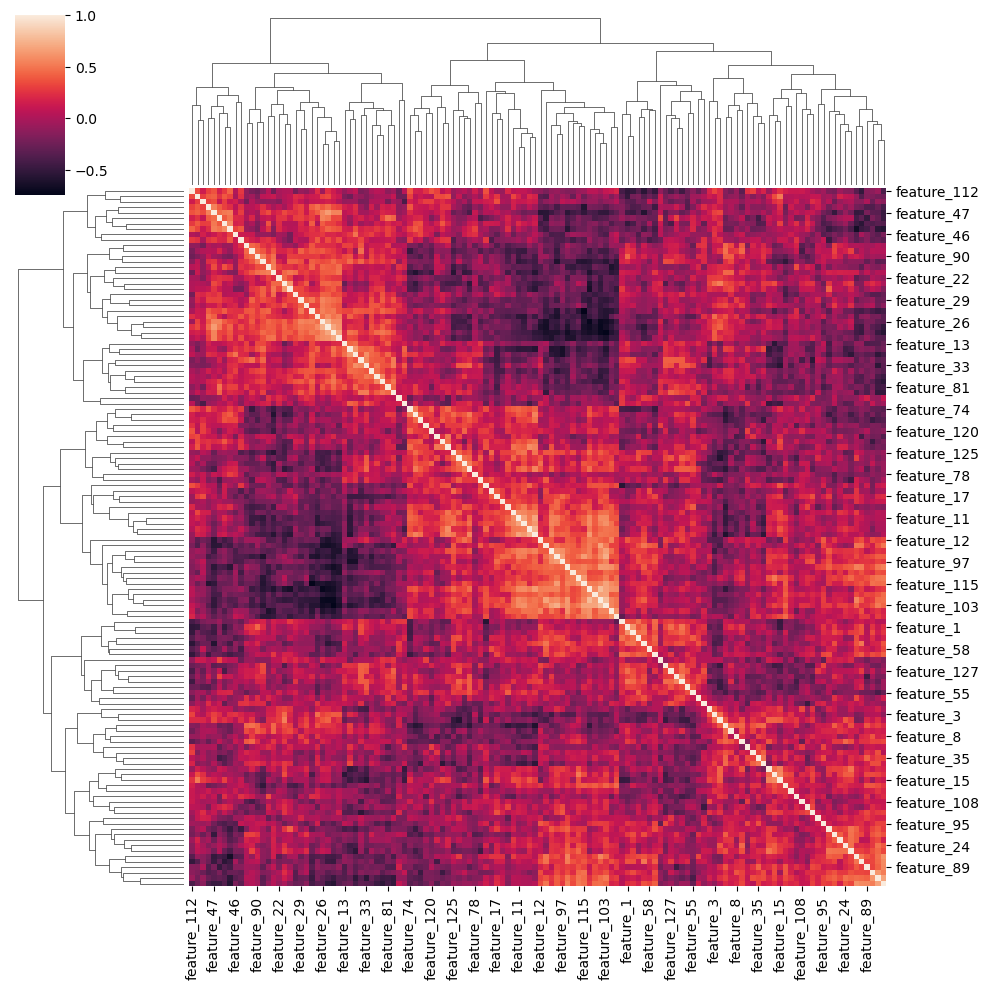

In [110]:
import seaborn as sns
well_ids = rxrx3_metadata.query('gene == "EGFR"')['well_id'].tolist()
gene_081_embeddings.pipe(lambda df: df[df.index.isin(well_ids)])
# data = gene_081_embeddings[gene_081_embeddings['well_id'].isin(rxrx3_metadata['gene'].isin(["EGFR"]))]

# data
# # data.set_index(['well_id', 'plate'], inplace=True)

sns.clustermap(gene_081_embeddings.corr())

In [213]:
from io import StringIO

drug2targets = pd.read_csv(StringIO(
"""
Drug	Target(s) (Gene Names)
Ulixertinib	MAPK1, MAPK3
Neratinib	EGFR, ERBB2, ERBB4
Tivozanib	FLT1, KDR, FLT4
Bortezomib	PSMB5
Bafetinib	ABL1, BCR, LYN
Gefitinib	EGFR
Celecoxib	PTGS2
Fostamatinib	SYK
Ruxolitinib	JAK1, JAK2
Nilotinib	ABL1, BCR, KIT, PDGFRA, PDGFRB
Lumiracoxib	PTGS2
Pexmetinib	TEK, MAPK14
Carfilzomib	PSMB5
Anlotinib	FLT1, KDR, FLT4, FGFR1, FGFR2, FGFR3, FGFR4, PDGFRA, PDGFRB, KIT
Ivosidenib	IDH1
Axitinib	FLT1, KDR, FLT4
Bosutinib	ABL1, BCR, SRC, LYN, FYN, YES1
Refametinib	MAP2K1, MAP2K2
Quizartinib	FLT3
Tipifarnib	FNTA, FNTB
Regorafenib	FLT1, KDR, FLT4, PDGFRB, FGFR1, FGFR2, FGFR3, FGFR4, KIT, RET, RAF1, BRAF
Lapatinib	EGFR, ERBB2
Lonafarnib	FNTA, FNTB
Parecoxib	PTGS2
Cabozantinib	MET, KDR, RET, AXL, KIT
Pazopanib	FLT1, KDR, FLT4, PDGFRA, PDGFRB, KIT
Imatinib	ABL1, BCR, KIT, PDGFRA, PDGFRB
Afatinib	EGFR, ERBB2, ERBB4
Golvatinib	MET, KDR
Gedatolisib	PIK3CA, PIK3CB, PIK3CG, PIK3CD, MTOR
Ponatinib	ABL1, BCR, FLT1, KDR, FLT4, FGFR1, FGFR2, FGFR3, FGFR4, PDGFRA, PDGFRB, SRC
Baricitinib	JAK1, JAK2
Icotinib	EGFR
Olaparib	PARP1, PARP2
Apatinib	KDR
Vandetanib	KDR, EGFR, RET
Dabrafenib	BRAF
Pexidartinib	CSF1R, KIT, FLT3
Olmutinib	EGFR
Etoricoxib	PTGS2
Entrectinib	NTRK1, NTRK2, NTRK3, ROS1, ALK
Sunitinib	KDR, PDGFRA, PDGFRB, KIT, FLT3, RET
Cobimetinib	MAP2K1, MAP2K2
Vismodegib	SMO
Enasidenib	IDH2
Brigatinib	ALK, ROS1, FLT3, IGF1R
Lenvatinib	FLT1, KDR, FLT4, FGFR1, FGFR2, FGFR3, FGFR4, PDGFRA, KIT, RET
Valdecoxib	PTGS2
Cerdulatinib	SYK, JAK1, JAK2, JAK3
Ispinesib	KIF11
Firocoxib	PTGS2
Cediranib	FLT1, KDR, FLT4, KIT, PDGFRA, PDGFRB
Acalabrutinib	BTK
Pacritinib	JAK2, FLT3
Palbociclib	CDK4, CDK6
Afuresertib	AKT1, AKT2, AKT3
Filgotinib	JAK1
Vemurafenib	BRAF
Sorafenib	RAF1, BRAF, KDR, FLT4, PDGFRB, KIT, FLT3
Deracoxib	PTGS2
Ibrutinib	BTK
Foretinib	MET, KDR, MST1R, AXL, TEK
Crizotinib	ALK, ROS1, MET
Erlotinib	EGFR
OSI-930	KIT, KDR, PDGFRA, PDGFRB
OSI-906	IGF1R, INSR
Dasatinib	ABL1, BCR, SRC, KIT, PDGFRB
OSI-420	EGFR
Dacomitinib	EGFR, ERBB2, ERBB4
Fruquintinib	FLT1, KDR, FLT4
Trametinib	MAP2K1, MAP2K2
OSI-027	MTOR
"""), delimiter='\t')
drug2targets.columns = ['compound', 'targets']

drug2targets.to_csv('small_molecule_targets.tsv', sep='\t', index=None)

,Drug,FDA Approval Status,Approved Indications,Clinical Trial Stage
0,Ulixertinib,Not Approved,None,Phase I/II
1,BI 2536,Not Approved,None,Phase I/II
2,Neratinib,Approved,Early-stage HER2-positive breast cancer,None
3,AZD1283,Not Approved,None,Preclinical or Phase I
4,GSK429286A,Not Approved,None,Preclinical
...,...,...,...,...
107,AZD5363,Not Approved,None,Phase III
108,Trametinib,Approved,Melanoma with BRAF V600E or V600K mutations,None
109,OSI-027,Not Approved,None,Phase I
110,NVP-AEW541,Not Approved,None,Preclinical


<Axes: xlabel='FDA Approval Status', ylabel='count'>

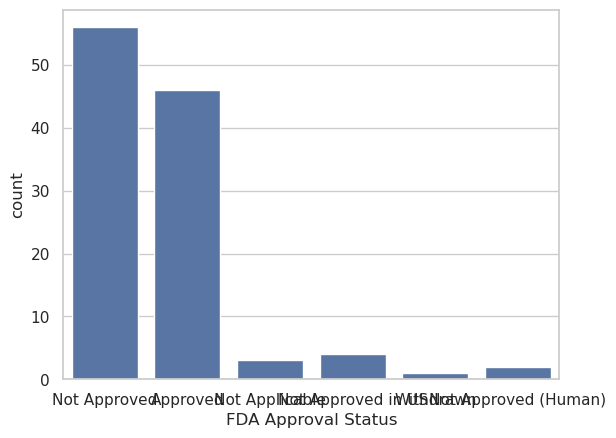

In [285]:
import pandas as pd

# Data list with FDA approval status and indications
drug_development_data = [
    ['Ulixertinib', 'Not Approved', None, 'Phase I/II'],
    ['BI 2536', 'Not Approved', None, 'Phase I/II'],
    ['Neratinib', 'Approved', 'Early-stage HER2-positive breast cancer', None],
    ['AZD1283', 'Not Approved', None, 'Preclinical or Phase I'],
    ['GSK429286A', 'Not Approved', None, 'Preclinical'],
    ['Tivozanib', 'Approved', 'Advanced renal cell carcinoma', None],
    ['GSK256066', 'Not Approved', None, 'Preclinical or Phase I'],
    ['Bortezomib', 'Approved', 'Multiple myeloma, mantle cell lymphoma', None],
    ['CPI-203', 'Not Approved', None, 'Phase I'],
    ['Bafetinib', 'Not Approved', None, 'Phase I/II'],
    ['Gefitinib', 'Approved', 'Non-small cell lung cancer with EGFR mutations', None],
    ['Celecoxib', 'Approved', 'Pain, osteoarthritis, rheumatoid arthritis, familial adenomatous polyposis', None],
    ['Fostamatinib', 'Approved', 'Immune thrombocytopenia (ITP)', None],
    ['PF-04929113', 'Not Approved', None, 'Phase I/II'],
    ['Ruxolitinib', 'Approved', 'Myelofibrosis, polycythemia vera, acute graft-versus-host disease', None],
    ['Nilotinib', 'Approved', 'Chronic myeloid leukemia (CML)', None],
    ['PF-477736', 'Not Approved', None, 'Phase I'],
    ['Lumiracoxib', 'Not Approved', None, 'Withdrawn due to safety concerns'],
    ['KPT-185', 'Not Applicable', None, 'Preclinical (tool compound)'],
    ['Pexmetinib', 'Not Approved', None, 'Phase I/II'],
    ['PF-562271', 'Not Approved', None, 'Phase I/II'],
    ['ABT-199', 'Approved', 'Chronic lymphocytic leukemia (CLL), acute myeloid leukemia (AML), small lymphocytic lymphoma (SLL)', None],
    ['Carfilzomib', 'Approved', 'Multiple myeloma', None],
    ['Anlotinib', 'Not Approved', None, 'Phase II/III'],
    ['GSK-1070916', 'Not Approved', None, 'Phase I'],
    ['Ivosidenib', 'Approved', 'Acute myeloid leukemia with IDH1 mutation', None],
    ['Axitinib', 'Approved', 'Advanced renal cell carcinoma', None],
    ['AZD3463', 'Not Approved', None, 'Preclinical or Phase I'],
    ['Bosutinib', 'Approved', 'Chronic myeloid leukemia (CML)', None],
    ['Refametinib', 'Not Approved', None, 'Phase II'],
    ['KPT-276', 'Not Applicable', None, 'Preclinical (tool compound)'],
    ['Quizartinib', 'Approved', 'Acute myeloid leukemia with FLT3-ITD mutation', None],
    ['Tipifarnib', 'Not Approved', None, 'Phase II/III'],
    ['ABT-263', 'Not Approved', None, 'Phase II'],
    ['GDC-0994', 'Not Approved', None, 'Phase I'],
    ['Regorafenib', 'Approved', 'Metastatic colorectal cancer, gastrointestinal stromal tumors, hepatocellular carcinoma', None],
    ['Lapatinib', 'Approved', 'Advanced or metastatic HER2-positive breast cancer', None],
    ['Lonafarnib', 'Approved', 'Hutchinson-Gilford Progeria Syndrome (HGPS)', None],
    ['Parecoxib', 'Not Approved in US', None, 'Available in some countries'],
    ['PF-04691502', 'Not Approved', None, 'Phase I/II'],
    ['BMS-777607', 'Not Approved', None, 'Phase I'],
    ['Cabozantinib', 'Approved', 'Advanced renal cell carcinoma, hepatocellular carcinoma, medullary thyroid cancer', None],
    ['Pazopanib', 'Approved', 'Advanced renal cell carcinoma, advanced soft tissue sarcoma', None],
    ['Imatinib', 'Approved', 'Chronic myeloid leukemia (CML), gastrointestinal stromal tumors (GIST)', None],
    ['Afatinib', 'Approved', 'Non-small cell lung cancer with EGFR mutations', None],
    ['GDC-0853', 'Not Approved', None, 'Phase II'],
    ['AZD2014', 'Not Approved', None, 'Phase II'],
    ['Golvatinib', 'Not Approved', None, 'Phase I/II'],
    ['Gedatolisib', 'Not Approved', None, 'Phase I/II'],
    ['Ponatinib', 'Approved', 'Chronic myeloid leukemia (CML), Philadelphia chromosome-positive acute lymphoblastic leukemia (Ph+ ALL)', None],
    ['Baricitinib', 'Approved', 'Rheumatoid arthritis, COVID-19', None],
    ['GDC-0032', 'Not Approved', None, 'Development discontinued'],
    ['Icotinib', 'Not Approved in US', None, 'Approved in China'],
    ['Olaparib', 'Approved', 'BRCA-mutated cancers (ovarian, breast, pancreatic, prostate)', None],
    ['Apatinib', 'Not Approved', None, 'Phase III'],
    ['Vandetanib', 'Approved', 'Medullary thyroid cancer', None],
    ['Dabrafenib', 'Approved', 'BRAF V600E-positive melanoma and non-small cell lung cancer', None],
    ['GDC-0084', 'Not Approved', None, 'Phase II/III'],
    ['Pexidartinib', 'Approved', 'Tenosynovial giant cell tumor (TGCT)', None],
    ['Olmutinib', 'Not Approved', None, 'Development discontinued'],
    ['AZD2858', 'Not Approved', None, 'Preclinical'],
    ['Etoricoxib', 'Not Approved in US', None, 'Approved elsewhere'],
    ['GSK2982772', 'Not Approved', None, 'Phase II'],
    ['BMS-794833', 'Not Approved', None, 'Phase I'],
    ['AZD7762', 'Not Approved', None, 'Phase I'],
    ['Entrectinib', 'Approved', 'NTRK fusion-positive solid tumors, ROS1-positive non-small cell lung cancer', None],
    ['Sunitinib', 'Approved', 'Renal cell carcinoma, gastrointestinal stromal tumors, pancreatic neuroendocrine tumors', None],
    ['Cobimetinib', 'Approved', 'Melanoma with BRAF V600E or V600K mutations (in combination with vemurafenib)', None],
    ['AZD4547', 'Not Approved', None, 'Phase II/III'],
    ['Vismodegib', 'Approved', 'Advanced basal cell carcinoma', None],
    ['AZD8330', 'Not Approved', None, 'Phase I/II'],
    ['GSK461364', 'Not Approved', None, 'Phase I'],
    ['KPT-330', 'Approved', 'Multiple myeloma, diffuse large B-cell lymphoma', None],
    ['Enasidenib', 'Approved', 'Acute myeloid leukemia with IDH2 mutation', None],
    ['Brigatinib', 'Approved', 'ALK-positive non-small cell lung cancer', None],
    ['Lenvatinib', 'Approved', 'Thyroid cancer, renal cell carcinoma, hepatocellular carcinoma, endometrial carcinoma', None],
    ['Valdecoxib', 'Withdrawn', None, 'Withdrawn due to safety concerns'],
    ['Cerdulatinib', 'Not Approved', None, 'Phase II'],
    ['Ispinesib', 'Not Approved', None, 'Phase I/II'],
    ['GSK1059615', 'Not Approved', None, 'Phase I'],
    ['Firocoxib', 'Not Approved (Human)', None, 'Approved for veterinary use'],
    ['AZD1080', 'Not Approved', None, 'Preclinical'],
    ['Cediranib', 'Not Approved', None, 'Phase III'],
    ['Acalabrutinib', 'Approved', 'Mantle cell lymphoma, chronic lymphocytic leukemia', None],
    ['GDC-0349', 'Not Approved', None, 'Phase I'],
    ['ABT-737', 'Not Approved', None, 'Preclinical'],
    ['Pacritinib', 'Not Approved', None, 'Phase III'],
    ['Palbociclib', 'Approved', 'HR-positive, HER2-negative advanced or metastatic breast cancer', None],
    ['Afuresertib', 'Not Approved', None, 'Phase II'],
    ['Filgotinib', 'Not Approved in US', None, 'Approved in Europe and Japan'],
    ['Vemurafenib', 'Approved', 'BRAF V600E-positive melanoma', None],
    ['Sorafenib', 'Approved', 'Hepatocellular carcinoma, renal cell carcinoma, thyroid cancer', None],
    ['Deracoxib', 'Not Approved (Human)', None, 'Approved for veterinary use'],
    ['Ibrutinib', 'Approved', 'Chronic lymphocytic leukemia, mantle cell lymphoma, Waldenström’s macroglobulinemia', None],
    ['BMS-927711', 'Not Approved', None, 'Development discontinued'],
    ['AZD9291', 'Approved', 'Non-small cell lung cancer with EGFR mutations', None],
    ['Foretinib', 'Not Approved', None, 'Phase II'],
    ['Crizotinib', 'Approved', 'ALK-positive and ROS1-positive non-small cell lung cancer', None],
    ['Erlotinib', 'Approved', 'Non-small cell lung cancer with EGFR mutations, pancreatic cancer', None],
    ['OSI-930', 'Not Approved', None, 'Phase I'],
    ['OSI-906', 'Not Approved', None, 'Phase III (failed)'],
    ['GSK2126458', 'Not Approved', None, 'Phase I'],
    ['Dasatinib', 'Approved', 'Chronic myeloid leukemia (CML), Philadelphia chromosome-positive acute lymphoblastic leukemia (Ph+ ALL)', None],
    ['OSI-420', 'Not Applicable', None, 'Metabolite of Erlotinib'],
    ['Dacomitinib', 'Approved', 'Non-small cell lung cancer with EGFR mutations', None],
    ['Fruquintinib', 'Not Approved', None, 'Phase III (approved in China)'],
    ['BMS-536924', 'Not Approved', None, 'Preclinical'],
    ['AZD5363', 'Not Approved', None, 'Phase III'],
    ['Trametinib', 'Approved', 'Melanoma with BRAF V600E or V600K mutations', None],
    ['OSI-027', 'Not Approved', None, 'Phase I'],
    ['NVP-AEW541', 'Not Approved', None, 'Preclinical'],
    ['NVP-TAE 684', 'Not Approved', None, 'Preclinical'],
]

# Create a DataFrame
df = pd.DataFrame(data, columns=['Drug', 'FDA Approval Status', 'Approved Indications', 'Clinical Trial Stage'])

# Display the DataFrame
df

# # Explode the 'Targets' column
# df_exploded = df.explode('targets')



# df_exploded.to_csv('small_molecule_targets.tsv', sep='\t')

sns.countplot(data=df, x='FDA Approval Status')

<Figure size 1200x600 with 0 Axes>

/tmp/ipykernel_26705/1728933502.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Development Stage', y='Number of Drugs', data=stage_counts, palette='viridis')


<Axes: xlabel='Development Stage', ylabel='Number of Drugs'>

Text(0.5, 1.0, 'Number of Drugs by Development Stage')

Text(0.5, 0, 'Development Stage')

Text(0, 0.5, 'Number of Drugs')

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Preclinical'),
  Text(1, 0, 'Phase I'),
  Text(2, 0, 'Phase I/II'),
  Text(3, 0, 'Phase II'),
  Text(4, 0, 'Phase II/III'),
  Text(5, 0, 'Phase III'),
  Text(6, 0, 'Approved'),
  Text(7, 0, 'Withdrawn'),
  Text(8, 0, 'Preclinical or Unknown')])

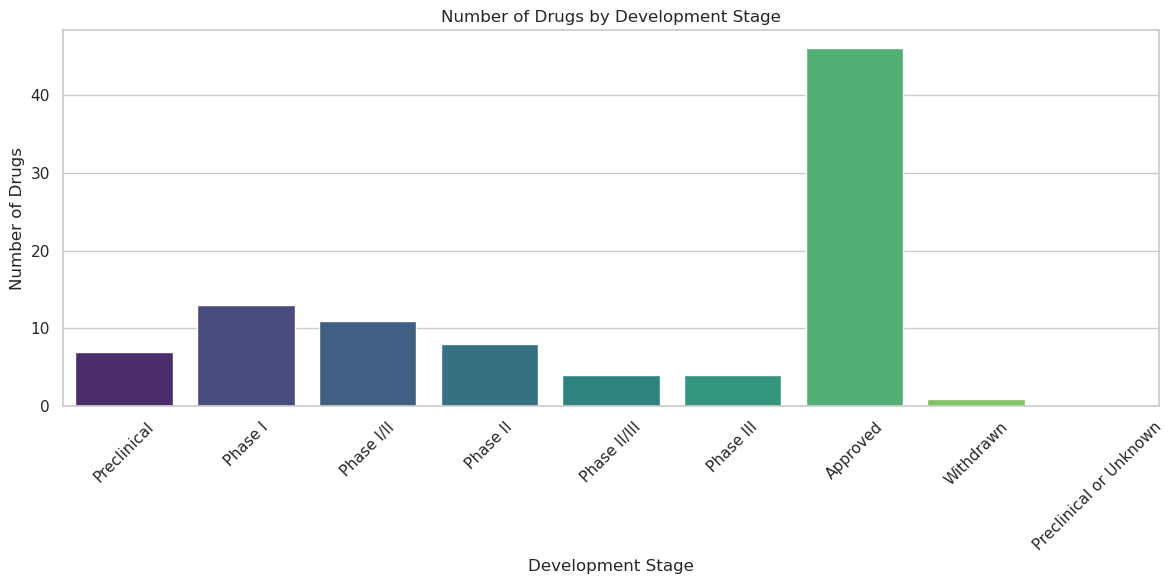

In [282]:
# Define function to get development stage
def get_development_stage(row):
    if row['FDA Approval Status'] == 'Approved':
        return 'Approved'
    elif row['FDA Approval Status'] == 'Withdrawn':
        return 'Withdrawn'
    elif pd.notnull(row['Clinical Trial Stage']):
        return row['Clinical Trial Stage']
    else:
        return 'Preclinical or Unknown'

# Apply function
df['Development Stage'] = df.apply(get_development_stage, axis=1)

# Aggregate data
stage_counts = df['Development Stage'].value_counts().reset_index()
stage_counts.columns = ['Development Stage', 'Number of Drugs']

# Define stage order
stage_order = ['Preclinical', 'Phase I', 'Phase I/II', 'Phase II', 'Phase II/III', 'Phase III', 'Approved', 'Withdrawn', 'Preclinical or Unknown']
stage_counts['Development Stage'] = pd.Categorical(stage_counts['Development Stage'], categories=stage_order, ordered=True)
stage_counts.sort_values('Development Stage', inplace=True)

# Plotting
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))
sns.barplot(x='Development Stage', y='Number of Drugs', data=stage_counts, palette='viridis')
plt.title('Number of Drugs by Development Stage')
plt.xlabel('Development Stage')
plt.ylabel('Number of Drugs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [284]:
# Updated data list
drug_target_data = [
    ['Ulixertinib', ['MAPK1', 'MAPK3']],
    ['BI 2536', ['PLK1']],
    ['Neratinib', ['EGFR', 'ERBB2', 'ERBB4']],
    ['AZD1283', ['SELP']],
    ['GSK429286A', ['ROCK1', 'ROCK2']],
    ['Tivozanib', ['FLT1', 'KDR', 'FLT4']],
    ['GSK256066', ['PDE4A', 'PDE4B', 'PDE4C', 'PDE4D']],
    ['Bortezomib', ['PSMB5']],
    ['CPI-203', ['BRD2', 'BRD3', 'BRD4']],
    ['Bafetinib', ['ABL1', 'BCR', 'LYN']],
    ['Gefitinib', ['EGFR']],
    ['Celecoxib', ['PTGS2']],
    ['Fostamatinib', ['SYK']],
    ['PF-04929113', ['HSP90AA1']],
    ['Ruxolitinib', ['JAK1', 'JAK2']],
    ['Nilotinib', ['ABL1', 'BCR', 'KIT', 'PDGFRA', 'PDGFRB']],
    ['PF-477736', ['CHEK1']],
    ['Lumiracoxib', ['PTGS2']],
    ['KPT-185', ['XPO1']],
    ['Pexmetinib', ['TEK', 'MAPK14']],
    ['PF-562271', ['PTK2', 'PTK2B']],
    ['ABT-199', ['BCL2']],
    ['Carfilzomib', ['PSMB5']],
    ['Anlotinib', ['FLT1', 'KDR', 'FLT4', 'FGFR1', 'FGFR2', 'FGFR3', 'FGFR4', 'PDGFRA', 'PDGFRB', 'KIT']],
    ['GSK-1070916', ['AURKB', 'AURKC']],
    ['Ivosidenib', ['IDH1']],
    ['Axitinib', ['FLT1', 'KDR', 'FLT4']],
    ['AZD3463', ['ALK', 'IGF1R']],
    ['Bosutinib', ['ABL1', 'BCR', 'SRC', 'LYN', 'FYN', 'YES1']],
    ['Refametinib', ['MAP2K1', 'MAP2K2']],
    ['KPT-276', ['XPO1']],
    ['Quizartinib', ['FLT3']],
    ['Tipifarnib', ['FNTA', 'FNTB']],
    ['ABT-263', ['BCL2', 'BCL2L1', 'BCL2L2']],
    ['GDC-0994', ['MAPK1', 'MAPK3']],
    ['Regorafenib', ['FLT1', 'KDR', 'FLT4', 'PDGFRB', 'FGFR1', 'FGFR2', 'FGFR3', 'FGFR4', 'KIT', 'RET', 'RAF1', 'BRAF']],
    ['Lapatinib', ['EGFR', 'ERBB2']],
    ['Lonafarnib', ['FNTA', 'FNTB']],
    ['Parecoxib', ['PTGS2']],
    ['PF-04691502', ['PIK3CA', 'PIK3CB', 'PIK3CD', 'PIK3CG', 'MTOR']],
    ['BMS-777607', ['MET', 'AXL', 'MST1R', 'TYRO3']],
    ['Cabozantinib', ['MET', 'KDR', 'RET', 'AXL', 'KIT']],
    ['Pazopanib', ['FLT1', 'KDR', 'FLT4', 'PDGFRA', 'PDGFRB', 'KIT']],
    ['Imatinib', ['ABL1', 'BCR', 'KIT', 'PDGFRA', 'PDGFRB']],
    ['Afatinib', ['EGFR', 'ERBB2', 'ERBB4']],
    ['GDC-0853', ['BTK']],
    ['AZD2014', ['MTOR']],
    ['Golvatinib', ['MET', 'KDR']],
    ['Gedatolisib', ['PIK3CA', 'PIK3CB', 'PIK3CG', 'PIK3CD', 'MTOR']],
    ['Ponatinib', ['ABL1', 'BCR', 'FLT1', 'KDR', 'FLT4', 'FGFR1', 'FGFR2', 'FGFR3', 'FGFR4', 'PDGFRA', 'PDGFRB', 'SRC']],
    ['Baricitinib', ['JAK1', 'JAK2']],
    ['GDC-0032', ['PIK3CA', 'PIK3CB', 'PIK3CD']],
    ['Icotinib', ['EGFR']],
    ['Olaparib', ['PARP1', 'PARP2']],
    ['Apatinib', ['KDR']],
    ['Vandetanib', ['KDR', 'EGFR', 'RET']],
    ['Dabrafenib', ['BRAF']],
    ['GDC-0084', ['PIK3CA', 'PIK3CB', 'PIK3CD', 'PIK3CG', 'MTOR']],
    ['Pexidartinib', ['CSF1R', 'KIT', 'FLT3']],
    ['Olmutinib', ['EGFR']],
    ['AZD2858', ['GSK3B']],
    ['Etoricoxib', ['PTGS2']],
    ['GSK2982772', ['RIPK1']],
    ['BMS-794833', ['KDR', 'FGFR1']],
    ['AZD7762', ['CHEK1', 'CHEK2']],
    ['Entrectinib', ['NTRK1', 'NTRK2', 'NTRK3', 'ROS1', 'ALK']],
    ['Sunitinib', ['KDR', 'PDGFRA', 'PDGFRB', 'KIT', 'FLT3', 'RET']],
    ['Cobimetinib', ['MAP2K1', 'MAP2K2']],
    ['AZD4547', ['FGFR1', 'FGFR2', 'FGFR3']],
    ['Vismodegib', ['SMO']],
    ['AZD8330', ['MAP2K1', 'MAP2K2']],
    ['GSK461364', ['PLK1']],
    ['KPT-330', ['XPO1']],
    ['Enasidenib', ['IDH2']],
    ['Brigatinib', ['ALK', 'ROS1', 'FLT3', 'IGF1R']],
    ['Lenvatinib', ['FLT1', 'KDR', 'FLT4', 'FGFR1', 'FGFR2', 'FGFR3', 'FGFR4', 'PDGFRA', 'KIT', 'RET']],
    ['Valdecoxib', ['PTGS2']],
    ['Cerdulatinib', ['SYK', 'JAK1', 'JAK2', 'JAK3']],
    ['Ispinesib', ['KIF11']],
    ['GSK1059615', ['PIK3CA', 'PIK3CB', 'PIK3CD', 'PIK3CG', 'MTOR']],
    ['Firocoxib', ['PTGS2']],
    ['AZD1080', ['GSK3A', 'GSK3B']],
    ['Cediranib', ['FLT1', 'KDR', 'FLT4', 'KIT', 'PDGFRA', 'PDGFRB']],
    ['Acalabrutinib', ['BTK']],
    ['GDC-0349', ['MTOR']],
    ['ABT-737', ['BCL2', 'BCL2L1', 'BCL2L2']],
    ['Pacritinib', ['JAK2', 'FLT3']],
    ['Palbociclib', ['CDK4', 'CDK6']],
    ['Afuresertib', ['AKT1', 'AKT2', 'AKT3']],
    ['Filgotinib', ['JAK1']],
    ['Vemurafenib', ['BRAF']],
    ['Sorafenib', ['RAF1', 'BRAF', 'KDR', 'FLT4', 'PDGFRB', 'KIT', 'FLT3']],
    ['Deracoxib', ['PTGS2']],
    ['Ibrutinib', ['BTK']],
    ['BMS-927711', ['CALCRL', 'RAMP1']],
    ['AZD9291', ['EGFR']],
    ['Foretinib', ['MET', 'KDR', 'MST1R', 'AXL', 'TEK']],
    ['Crizotinib', ['ALK', 'ROS1', 'MET']],
    ['Erlotinib', ['EGFR']],
    ['OSI-930', ['KIT', 'KDR', 'PDGFRA', 'PDGFRB']],
    ['OSI-906', ['IGF1R', 'INSR']],
    ['GSK2126458', ['PIK3CA', 'PIK3CB', 'PIK3CD', 'PIK3CG', 'MTOR']],
    ['Dasatinib', ['ABL1', 'BCR', 'SRC', 'KIT', 'PDGFRB']],
    ['OSI-420', ['EGFR']],
    ['Dacomitinib', ['EGFR', 'ERBB2', 'ERBB4']],
    ['Fruquintinib', ['FLT1', 'KDR', 'FLT4']],
    ['BMS-536924', ['IGF1R']],
    ['AZD5363', ['AKT1', 'AKT2', 'AKT3']],
    ['Trametinib', ['MAP2K1', 'MAP2K2']],
    ['OSI-027', ['MTOR']],
    ['NVP-AEW541', ['IGF1R']],
    ['NVP-TAE 684', ['ALK']],
]


<Figure size 1500x800 with 0 Axes>

/tmp/ipykernel_26705/2154396860.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Targets', y='Total Drug Count', data=total_target_counts, palette='viridis')


<Axes: xlabel='Targets', ylabel='Total Drug Count'>

Text(0.5, 1.0, 'Number of Drugs Targeting Each Gene')

Text(0.5, 0, 'Target Gene')

Text(0, 0.5, 'Number of Drugs')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92],
 [Text(0, 0, 'KDR'),
  Text(1, 0, 'KIT'),
  Text(2, 0, 'PDGFRB'),
  Text(3, 0, 'EGFR'),
  Text(4, 0, 'FLT4'),
  Text(5, 0, 'FLT1'),
  Text(6, 0, 'PDGFRA'),
  Text(7, 0, 'MTOR'),
  Text(8, 0, 'PTGS2'),
  Text(9, 0, 'FLT3'),
  Text(10, 0, 'PIK3CD'),
  Text(11, 0, 'ABL1'),
  Text(12, 0, 'PIK3CB'),
  Text(13, 0, 'PIK3CA'),
  Text(14, 0, 'FGFR1'),
  Text(15, 0, 'BCR'),
  Text(16, 0, 'FGFR3'),
  Text(17, 0, 'MET'),
  Text(18, 0, 'PIK3CG'),
  Text(19, 0,

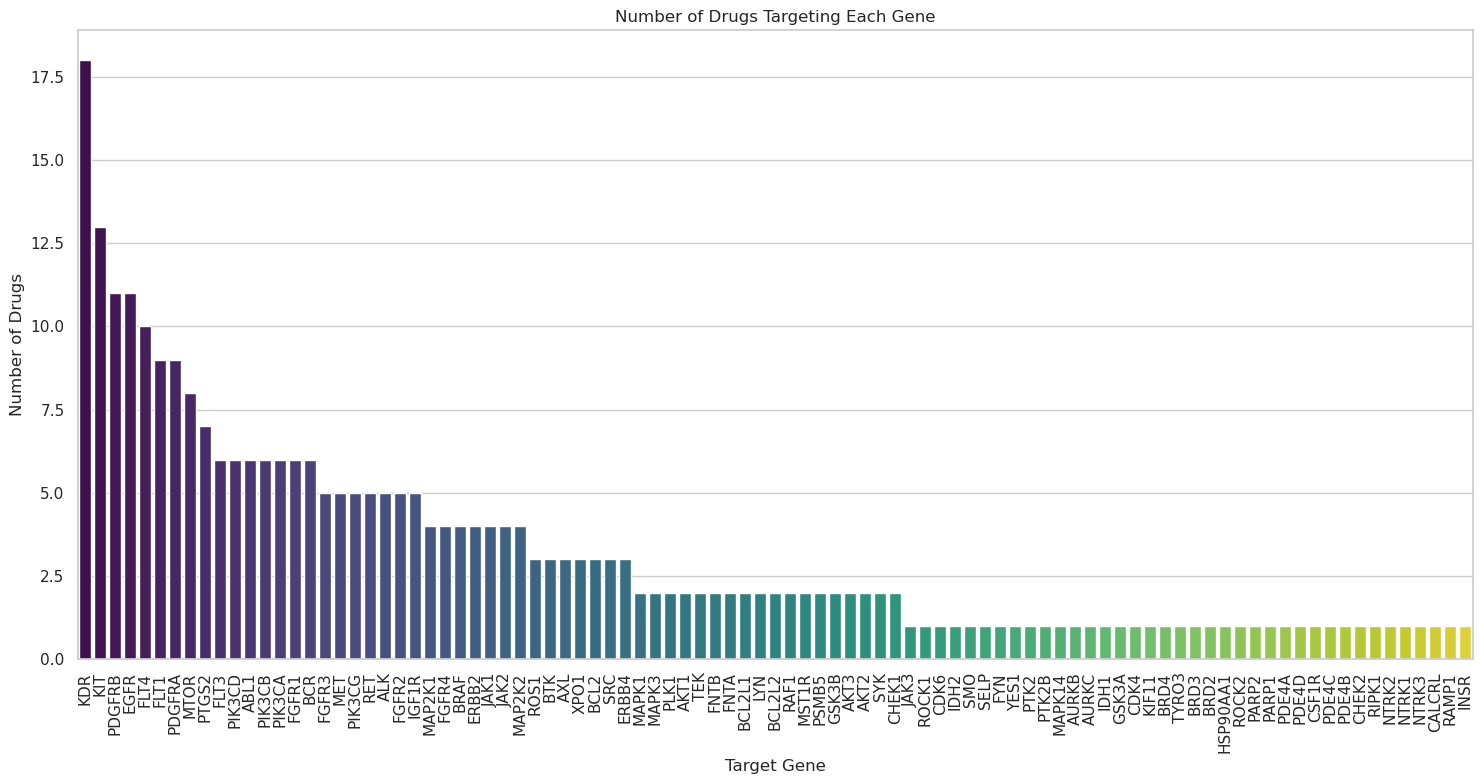

<Figure size 1500x1000 with 0 Axes>

<Axes: xlabel='Development Stage', ylabel='Targets'>

Text(0.5, 1.0, 'Number of Drugs per Target Gene and Development Stage')

Text(0.5, 76.24999999999999, 'Development Stage')

Text(153.75, 0.5, 'Target Gene')

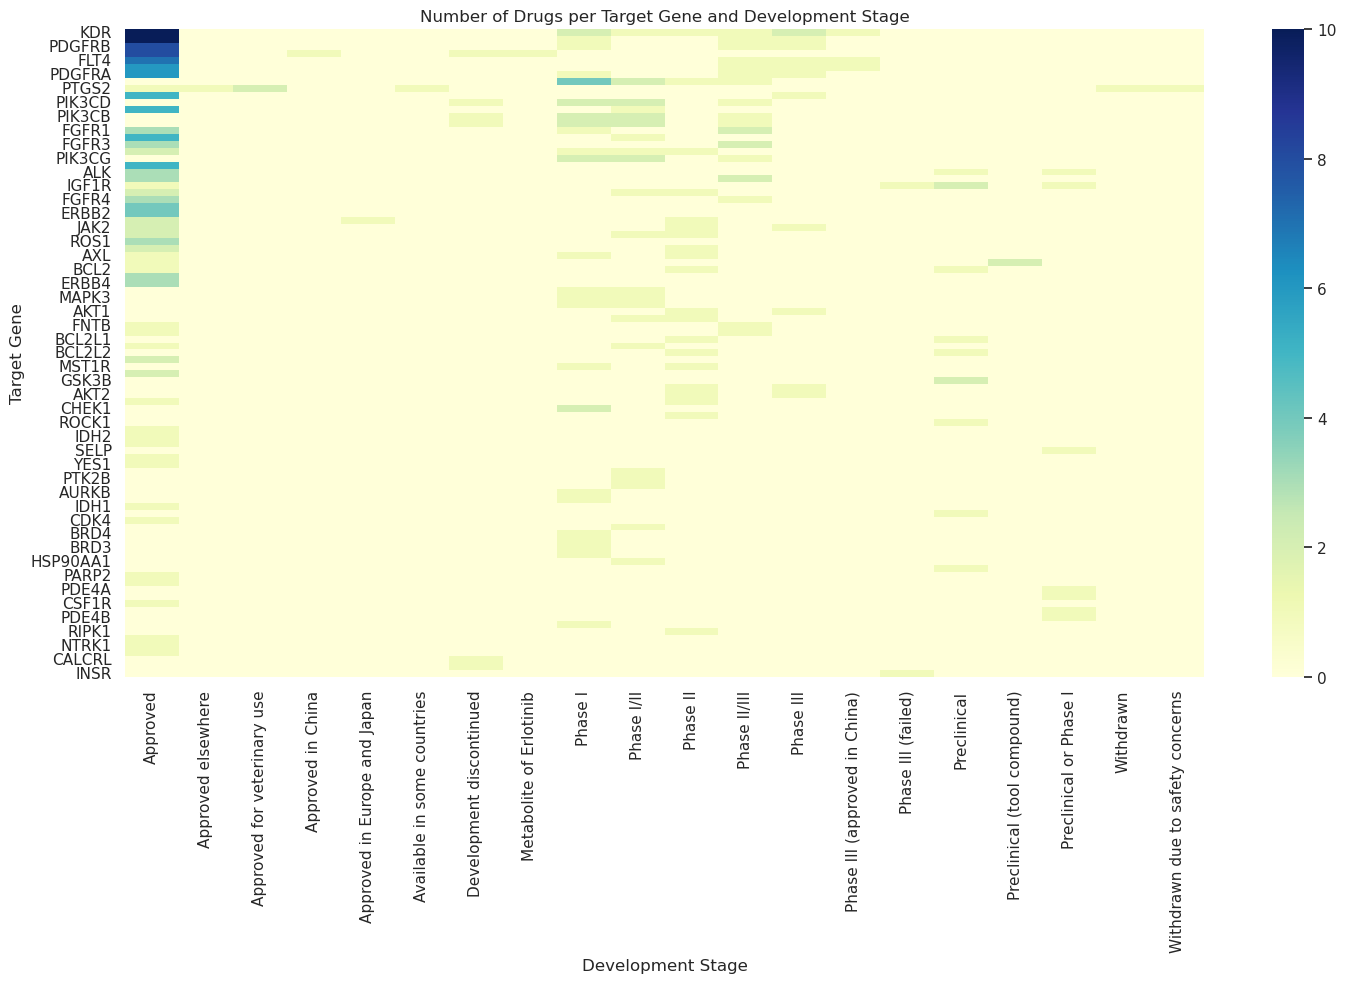

<Axes: xlabel='Targets'>

Text(0.5, 1.0, 'Number of Drugs per Target Gene by Development Stage')

Text(0.5, 0, 'Target Gene')

Text(0, 0.5, 'Number of Drugs')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92]),
 [Text(0, 0, 'KDR'),
  Text(1, 0, 'KIT'),
  Text(2, 0, 'PDGFRB'),
  Text(3, 0, 'EGFR'),
  Text(4, 0, 'FLT4'),
  Text(5, 0, 'FLT1'),
  Text(6, 0, 'PDGFRA'),
  Text(7, 0, 'MTOR'),
  Text(8, 0, 'PTGS2'),
  Text(9, 0, 'FLT3'),
  Text(10, 0, 'PIK3CD'),
  Text(11, 0, 'ABL1'),
  Text(12, 0, 'PIK3CB'),
  Text(13, 0, 'PIK3CA'),
  Text(14, 0, 'FGFR1'),
  Text(15, 0, 'BCR'),
  Text(16, 0, 'FGFR3'),
  Text(17, 0, 'MET'),
  Text(18, 0, 'PIK3CG'),
  Text(19, 0, 'RET'),
  Text(20, 0, 'ALK'),
  Text(21, 0, 'FGFR2'),
  Text(22, 0, 'IGF1R'),
  Text(23, 0, 'MAP2K1'),
  Text(24, 0, 'FGFR4'),

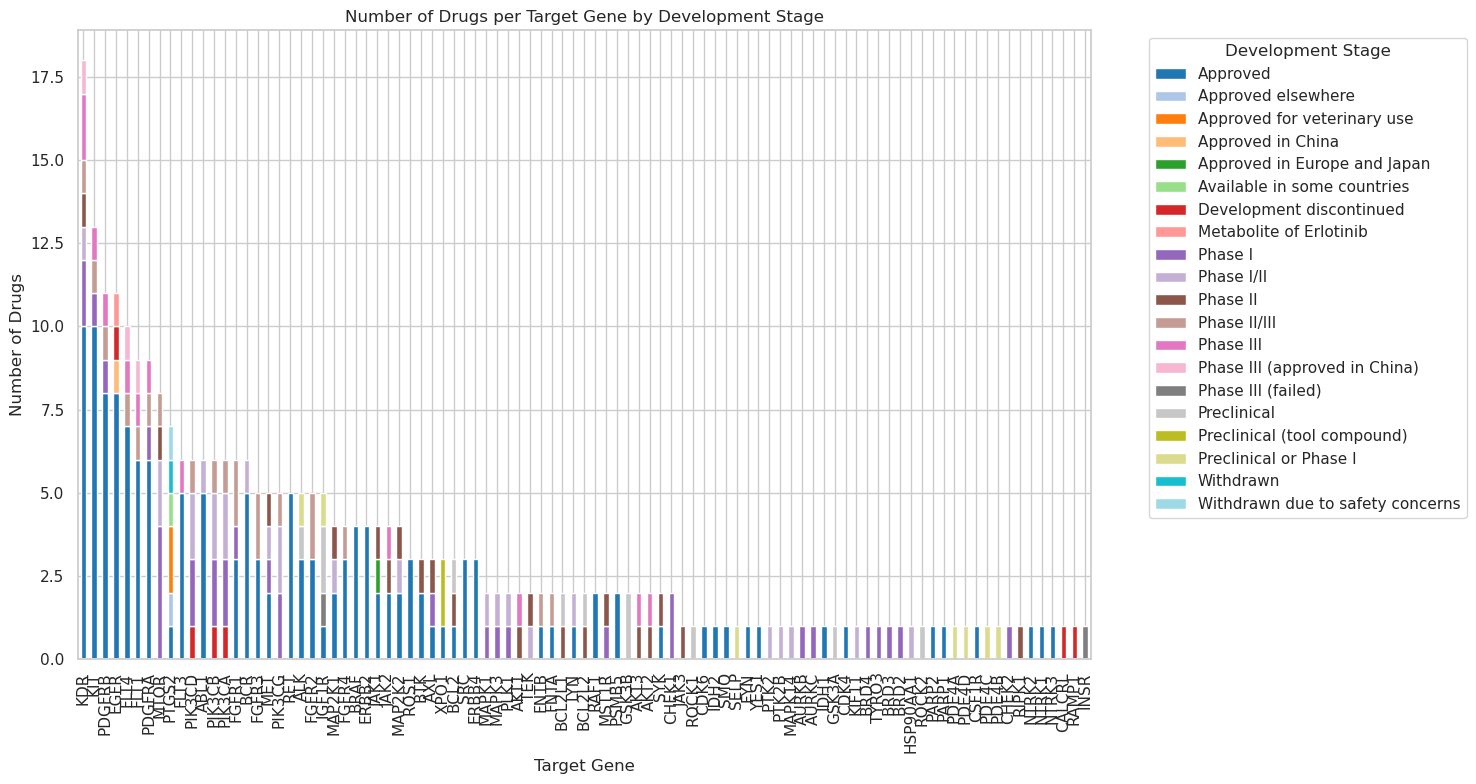

In [300]:
# Create DataFrames
df_targets = pd.DataFrame(drug_target_data, columns=['Drug', 'Targets'])
df_development = pd.DataFrame(drug_development_data, columns=['Drug', 'FDA Approval Status', 'Approved Indications', 'Clinical Trial Stage'])

# Merge DataFrames
df_merged = pd.merge(df_targets, df_development, on='Drug', how='left')

# Explode the 'Targets' column
df_exploded = df_merged.explode('Targets').reset_index(drop=True)

# Define function to get development stage
def get_development_stage(row):
    if row['FDA Approval Status'] == 'Approved':
        return 'Approved'
    elif row['FDA Approval Status'] == 'Withdrawn':
        return 'Withdrawn'
    elif pd.notnull(row['Clinical Trial Stage']):
        return row['Clinical Trial Stage']
    else:
        return 'Preclinical or Unknown'

# Apply function
df_exploded['Development Stage'] = df_exploded.apply(get_development_stage, axis=1)

# Group by 'Targets' and 'Development Stage'
target_counts = df_exploded.groupby(['Targets', 'Development Stage']).size().reset_index(name='Drug Count')

# Get total counts per target
total_target_counts = df_exploded['Targets'].value_counts().reset_index()
total_target_counts.columns = ['Targets', 'Total Drug Count']

# Merge total counts
target_counts = pd.merge(target_counts, total_target_counts, on='Targets', how='left')

# Set plot style
sns.set(style='whitegrid')

# 1. Bar Plot of Total Drugs per Target
plt.figure(figsize=(15, 8))
sns.barplot(x='Targets', y='Total Drug Count', data=total_target_counts, palette='viridis')
plt.title('Number of Drugs Targeting Each Gene')
plt.xlabel('Target Gene')
plt.ylabel('Number of Drugs')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 2. Heatmap of Drugs per Target and Development Stage
pivot_table = df_exploded.pivot_table(index='Targets', columns='Development Stage', aggfunc='size', fill_value=0)
pivot_table = pivot_table.loc[total_target_counts['Targets']]
plt.figure(figsize=(15, 10))
sns.heatmap(pivot_table, annot=False, fmt='d', cmap='YlGnBu')
plt.title('Number of Drugs per Target Gene and Development Stage')
plt.xlabel('Development Stage')
plt.ylabel('Target Gene')
plt.tight_layout()
plt.show()

# 3. Stacked Bar Plot of Drugs per Target and Development Stage
stacked_data = df_exploded.groupby(['Targets', 'Development Stage']).size().unstack(fill_value=0)
stacked_data = stacked_data.loc[total_target_counts['Targets']]
stacked_data.plot(kind='bar', stacked=True, figsize=(15, 8), colormap='tab20')
plt.title('Number of Drugs per Target Gene by Development Stage')
plt.xlabel('Target Gene')
plt.ylabel('Number of Drugs')
plt.xticks(rotation=90)
plt.legend(title='Development Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<Axes: xlabel='Targets'>

Text(0.5, 1.0, 'Number of Drugs per Target Gene by Development Stage')

Text(0.5, 0, 'Target Gene')

Text(0, 0.5, 'Number of Drugs')

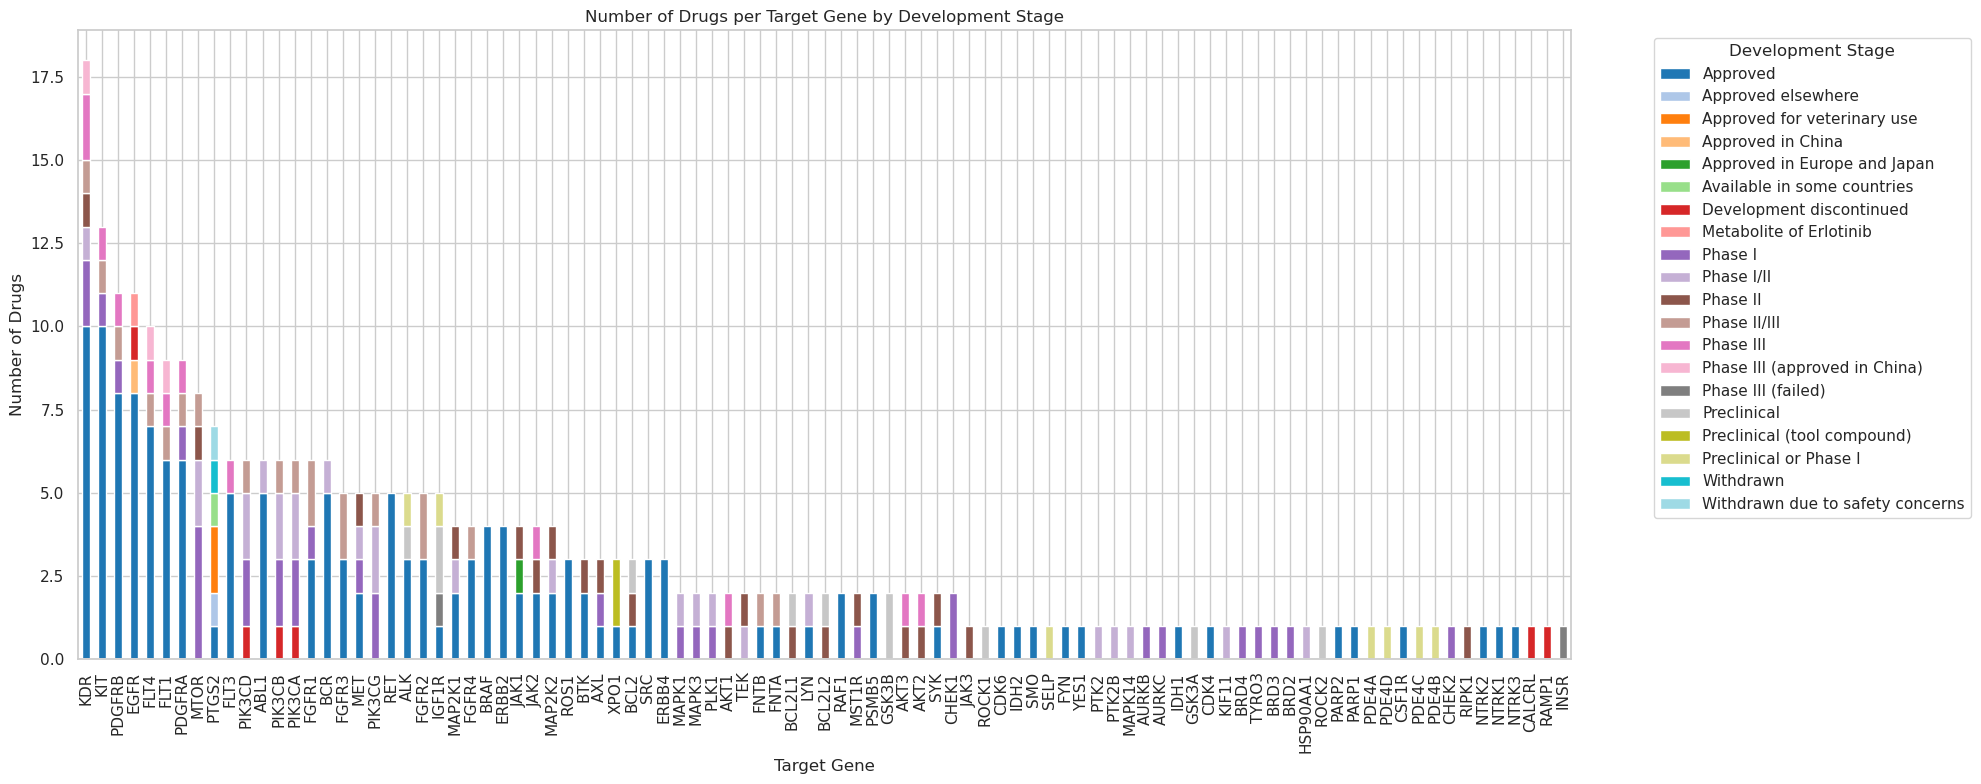

In [306]:
# 3. Stacked Bar Plot of Drugs per Target and Development Stage
stacked_data = df_exploded.groupby(['Targets', 'Development Stage']).size().unstack(fill_value=0)
stacked_data = stacked_data.loc[total_target_counts['Targets']]
stacked_data.plot(kind='bar', stacked=True, figsize=(20, 8), colormap='tab20')
plt.title('Number of Drugs per Target Gene by Development Stage')
plt.xlabel('Target Gene')
plt.ylabel('Number of Drugs')
_ = plt.xticks(rotation=90)
plt.legend(title='Development Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [303]:
df_exploded.query('Targets == "INSR"')

,Drug,Targets,FDA Approval Status,Approved Indications,Clinical Trial Stage,Development Stage
269,OSI-906,INSR,Not Approved,None,Phase III (failed),Phase III (failed)


<Figure size 1400x2000 with 0 Axes>

<Axes: xlabel='Development Stage'>

Text(0.5, 1.0, 'Number of Drugs per Target Gene and Development Stage')

Text(0.5, 186.24999999999997, 'Development Stage')

Text(141.25, 0.5, 'Target Gene')

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0.5, 0, 'Preclinical'),
  Text(1.5, 0, 'Phase I'),
  Text(2.5, 0, 'Phase I/II'),
  Text(3.5, 0, 'Phase II'),
  Text(4.5, 0, 'Phase II/III'),
  Text(5.5, 0, 'Phase III'),
  Text(6.5, 0, 'Approved'),
  Text(7.5, 0, 'Withdrawn')])

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
        44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5, 53.5, 54.5,
        55.5, 56.5, 57.5, 58.5, 59.5, 60.5, 61.5, 62.5, 63.5, 64.5, 65.5,
        66.5, 67.5, 68.5, 69.5, 70.5, 71.5, 72.5, 73.5, 74.5, 75.5, 76.5,
        77.5, 78.5, 79.5, 80.5, 81.5, 82.5, 83.5, 84.5, 85.5, 86.5, 87.5,
        88.5, 89.5, 90.5, 91.5, 92.5]),
 [Text(0, 0.5, 'KDR'),
  Text(0, 1.5, 'KIT'),
  Text(0, 2.5, 'PDGFRB'),
  Text(0, 3.5, 'EGFR'),
  Text(0, 4.5, 'FLT4'),
  Text(0, 5.5, 'FLT1'),
  Text(0, 6.5, 'PDGFRA'),
  Text(0, 7.5, 'MTOR'),
  Text(0, 8.5, 'PTGS2'),
  Text(0, 9.5, 'FLT3'),
  Text(0, 10.5, 'PIK3CD'),
  Text(0, 11.5, 'ABL1'),
  Text(0, 12.5, 'PIK3CB'),
  Text(0, 13.5, 'PIK3CA'),
  Text(0, 14.5, 'FG

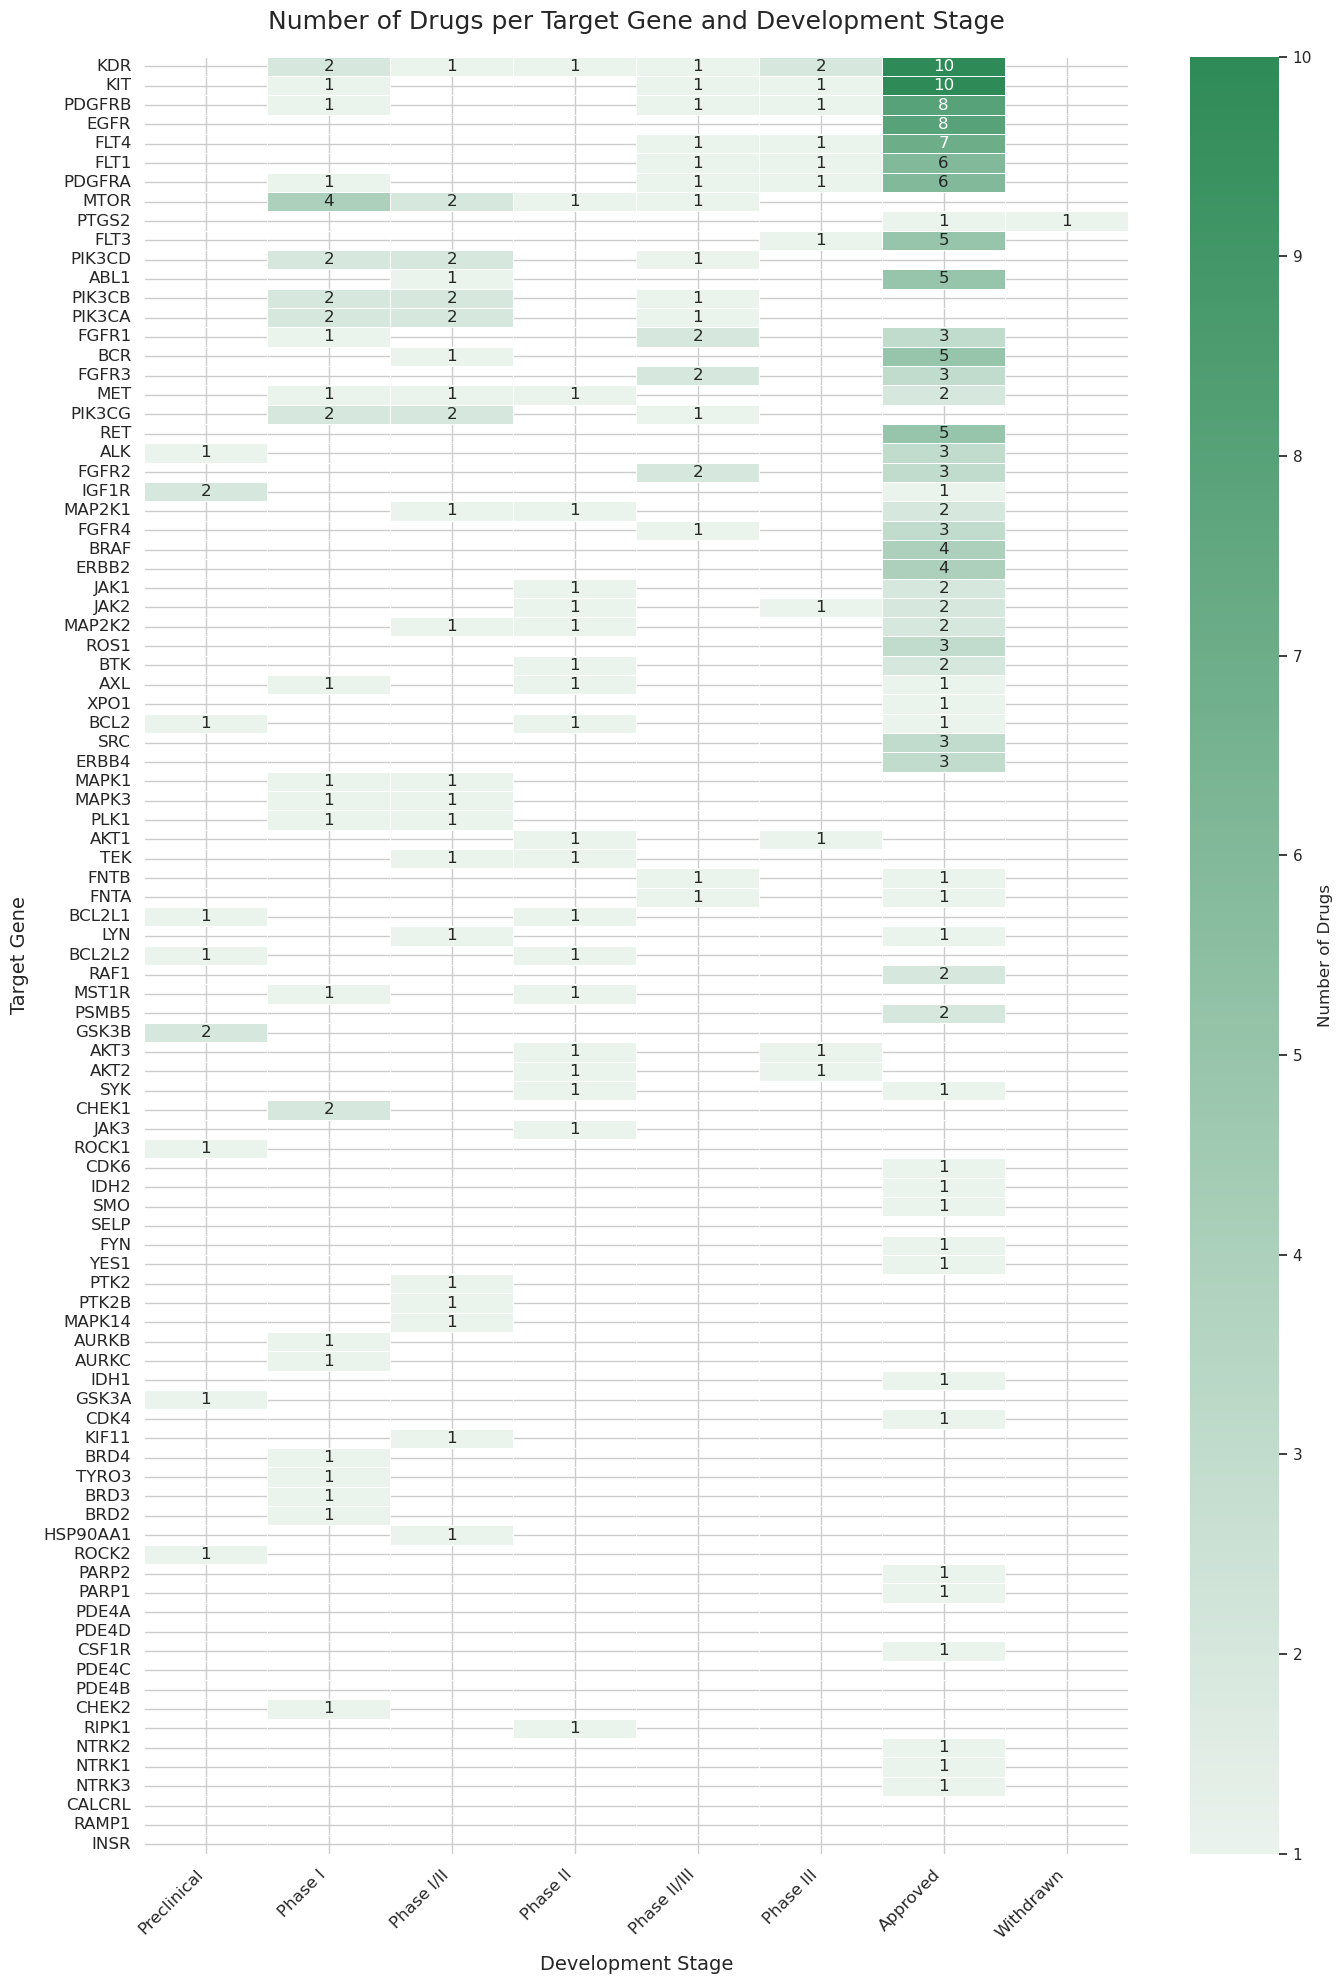

In [289]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_exploded is already defined from previous steps

# Define the order of development stages
development_stages = ['Preclinical', 'Phase I', 'Phase I/II', 'Phase II', 'Phase II/III', 'Phase III', 'Approved', 'Withdrawn']

# Create a pivot table with the defined order
pivot_table = df_exploded.pivot_table(index='Targets', columns='Development Stage', aggfunc='size', fill_value=0)
pivot_table = pivot_table.reindex(columns=development_stages, fill_value=0)

# Reorder targets based on total drug count
target_order = df_exploded['Targets'].value_counts().index
pivot_table = pivot_table.reindex(target_order)

# Set up the matplotlib figure
plt.figure(figsize=(14, 20))

# Use a sequential color palette
cmap = sns.light_palette("seagreen", as_cmap=True)

# Generate a mask for zero values
mask = pivot_table == 0

# Draw the heatmap with the mask
sns.heatmap(
    pivot_table,
    mask=mask,
    cmap=cmap,
    linewidths=0.5,
    annot=True,
    fmt='d',
    cbar_kws={'label': 'Number of Drugs'},
    square=False
)

# Customize the plot
plt.title('Number of Drugs per Target Gene and Development Stage', fontsize=18, pad=20)
plt.xlabel('Development Stage', fontsize=14, labelpad=10)
plt.ylabel('Target Gene', fontsize=14, labelpad=10)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


<Figure size 1400x1600 with 0 Axes>

Text(0.5, 1.0, 'Number of Drugs per Target Gene by Development Stage')

Text(0.5, 0, 'Number of Drugs')

Text(0, 0.5, 'Target Gene')

<Figure size 1400x1600 with 0 Axes>

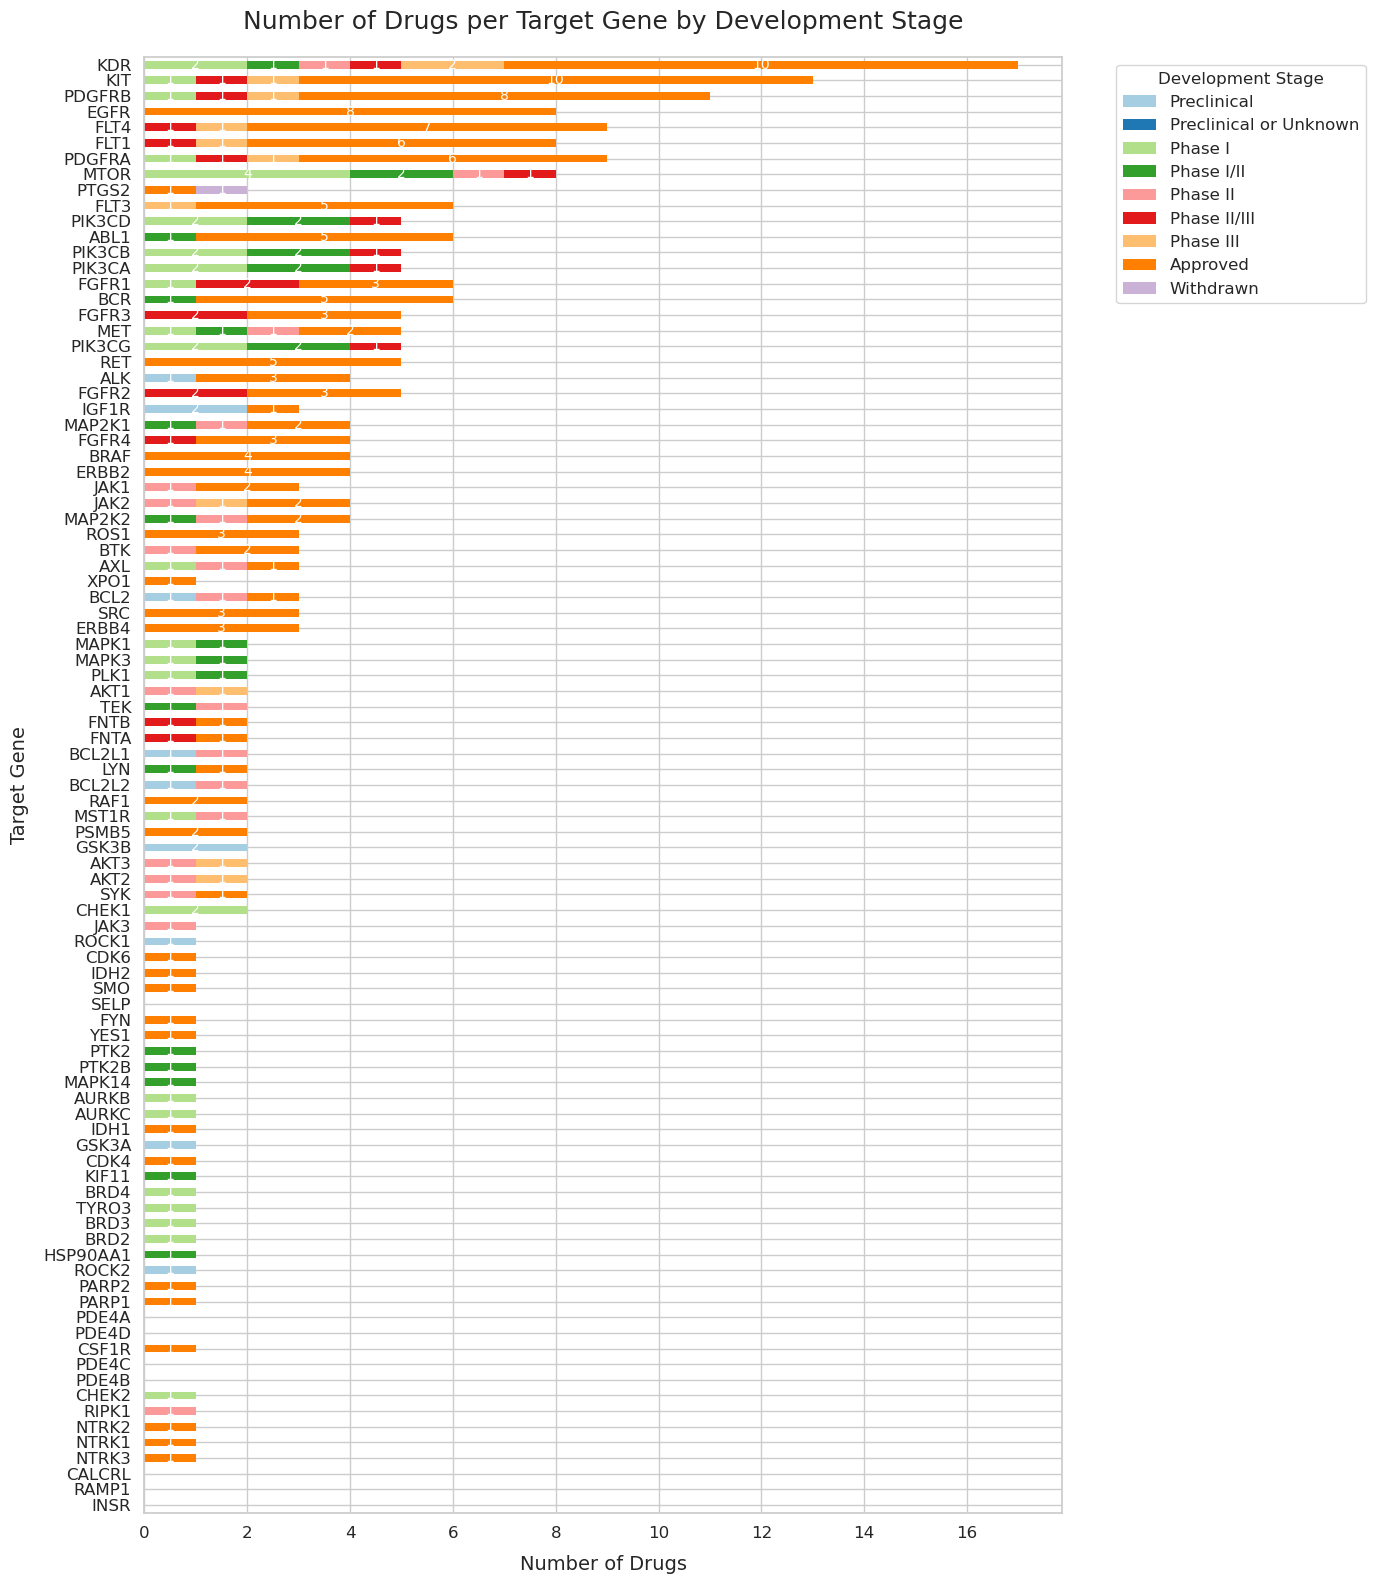

In [296]:
# Prepare data for the stacked bar plot
stacked_data = df_exploded.groupby(['Targets', 'Development Stage']).size().unstack(fill_value=0)

# Define the order of development stages
# Define the order of development stages, including all stages from the data
development_stages = [
    'Preclinical', 'Preclinical or Unknown', 'Phase I', 'Phase I/II',
    'Phase II', 'Phase II/III', 'Phase III', 'Approved', 'Withdrawn'
]
# Prepare data for the stacked bar plot
stacked_data = df_exploded.groupby(['Targets', 'Development Stage']).size().unstack(fill_value=0)

# Reindex the DataFrame to include all development stages
stacked_data = stacked_data.reindex(columns=development_stages, fill_value=0)

# Reorder targets based on total drug count
total_counts = df_exploded['Targets'].value_counts()
stacked_data = stacked_data.loc[total_counts.index]

# Set up the figure
plt.figure(figsize=(14, 16))

# Define a color palette
palette = sns.color_palette('Paired', n_colors=len(development_stages))

# Plot the stacked horizontal bar chart
ax = stacked_data.plot(
    kind='barh',
    stacked=True,
    figsize=(14, 16),
    color=palette,
    edgecolor='none'
)

# Customize the plot
plt.title('Number of Drugs per Target Gene by Development Stage', fontsize=18, pad=20)
plt.xlabel('Number of Drugs', fontsize=14, labelpad=10)
plt.ylabel('Target Gene', fontsize=14, labelpad=10)
_ = plt.xticks(fontsize=12)
_ = plt.yticks(fontsize=12)
plt.legend(title='Development Stage', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.gca().invert_yaxis()  # Highest values on top
_ = plt.tight_layout()

# Add data labels to each segment
for i in ax.patches:
    # Get width and position of the bar segment
    width = i.get_width()
    if width > 0:
        x = i.get_x() + width / 2
        y = i.get_y() + i.get_height() / 2
        # Add text label
        _ = ax.text(x, y, int(width), ha='center', va='center', fontsize=10, color='white')

# Show the plot
plt.show()


In [299]:
stacked_data.loc['INSR', :]

Development Stage
Preclinical               0
Preclinical or Unknown    0
Phase I                   0
Phase I/II                0
Phase II                  0
Phase II/III              0
Phase III                 0
Approved                  0
Withdrawn                 0
Name: INSR, dtype: int64